In [1]:
import os
import glob
import re
import pandas as pd
from dodfminer.extract.polished.acts.aposentadoria import Retirements
import numpy as np
from itertools import zip_longest
from itertools import chain
from collections import Counter
import gc
from matplotlib import pyplot as plt

dncols = ['date', 'num']

In [2]:
def get_reverse_date(s):
    date = re.search( r'((\d+)[-](\d+)[-](\d+))', s)
    date = date.group()
    date = '-'.join(date.split('-')[::-1])
    return date

def get_num(s):
    return int(re.search('(\d+)', s).group())

## Quantos DODFs baixados?

In [3]:
df = pd.DataFrame()
dodfs_text = glob.glob('data/dodfs_flat/*.txt')
df['file'] = [i.split('/')[-1] for i in dodfs_text]
df['date'] = [get_reverse_date(s) for s in df.file]
# df['date'] = pd.to_datetime(df.date)
df['num'] = [get_num(s) for s in df.file]
df.drop('file', axis=1, inplace=True)
len(dodfs_text)

595

## Quantos tiveram aposentadoria detectada?

In [4]:
%%time
dodfs_ext = [Retirements(i, 'regex') for i in dodfs_text]

df['has_act'] = [not i.data_frame.empty for i in dodfs_ext] 
df['qtd_miner'] = [i.data_frame.shape[0] for i in dodfs_ext]
print("TOTAL DE ARQUIVOS COM APOSENTADORIAS:", df[df.has_act].shape[0])

TOTAL DE ARQUIVOS COM APOSENTADORIAS: 227
CPU times: user 13.3 s, sys: 247 ms, total: 13.5 s
Wall time: 13.7 s


In [5]:
douro = pd.read_csv('data/aposentadoria-ouro/aposentaria-ouro-®.csv',
            sep='®', engine='python', index_col=False,)
douro.head(1)

,REF_ANOMES,DATA_DODF,NUM_DODF,PAGINA_DODF,TIPO_DODF,ATO,COD_EMPRESA,EMPRESA_ATO,COD_MATRICULA_ATO,COD_MATRICULA_SIGRH,CPF,NOME_ATO,NOME_SIGRH,CARGO,CLASSE,PADRAO,QUADRO,PROCESSO,FUND_LEGAL
0,201901,2019-01-01,248,PAGINA 14,NORMAL,CONCEDER APOSENTADORIA,NaN,"SECRETARIA DE ESTADO DE PLANEJAMENTO, ORCAMENT...",00317276,00317276,36868604149,MARIA DE JESUS BARBOSA SANTOS,MARIA DE JESUS BARBOSA SANTOS,ANALISTA EM POLITICAS PUBLICAS E GESTAO GOVERN...,CLASSE ESPECIAL,PADRAO V,QUADRO DE PESSOAL DO DISTRITO FEDERAL,00410-00015650/2018-74,"NOS TERMOS DO ARTIGO 3º, INCISOS I, II E III, ..."


In [6]:
# 'TIPO_DODF' é apenas uma coluna para depois contar
cols = ['DATA_DODF', 'NUM_DODF', 'TIPO_DODF']


_ = douro[cols].copy()
_.rename({'DATA_DODF':'date', 'NUM_DODF':'num'}
         , axis=1, inplace=True)

gp_ouro = _.groupby(['date', 'num']).count()
gp_ouro.columns = ['qtd_ouro']
gp_ouro.sort_values(['date', 'num'], inplace=True)

gp_miner = df[df.has_act].copy()
gp_miner.sort_values(['date', 'num'], inplace=True)
gp_miner.set_index(['date', 'num'], inplace=True)
gp_miner.drop('has_act', axis=1, inplace=True)

del _
gc.collect()

44

## Carregar índices (data, num) em comum

In [8]:
# `sum` por causa de ('2019-04-05', 65) que 
# parece ter pego de dois DODFs com msm numero e data, mas
# de tipos de edição diferentes
df_common = pd.read_csv('date-num-plot.csv', index_col=False)
df_common = pd.read_csv('date-num-plot.csv', index_col=False)
df_common.set_index(['date', 'num'], inplace=True)

## Salvar csv com os valores contados, mas apenas dos que aparecem no índice de df_common

In [9]:
miner_df = gp_miner.copy().groupby(dncols).sum().loc[
    df_common.index
]
ouro_df = gp_ouro.loc[df_common.index]
assert miner_df.shape == ouro_df.shape
assert np.all(miner_df.index == ouro_df.index)

In [10]:
df_compare = miner_df.join([ouro_df])
df_compare.sample(3)

,,qtd_miner,qtd_ouro
date,num,,
2019-05-17,92,28,28
2018-10-11,195,37,37
2018-11-27,225,2,20


In [11]:
df_compare.reset_index().to_csv('extract_compare.csv', index=False)

# Plotar os gráficos

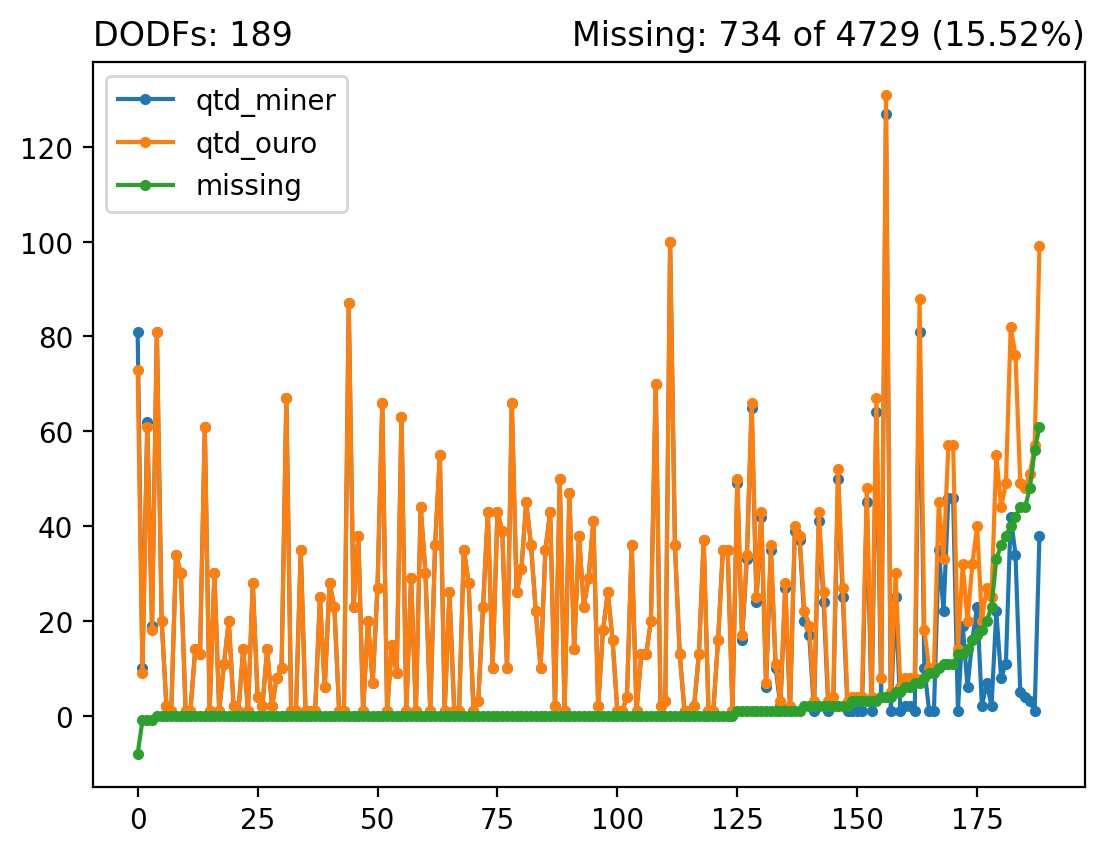

In [12]:
df_compare['missing'] = df_compare.qtd_ouro - df_compare.qtd_miner
df_compare.sort_values('missing', inplace=True)
plt.figure(figsize=(6.4, 4.8), dpi=200)
for c in df_compare.columns:
    plt.plot(range(df_compare.shape[0]), df_compare[c], marker='.')
plt.legend(df_compare.columns);
plt.title(
    f'Missing: {df_compare.missing.sum()} of {df_compare.qtd_ouro.sum()}'
    f' ({(df_compare.missing.sum()/df_compare.qtd_ouro.sum())*100:.2f}%)',
    loc='right');
plt.title(f'DODFs: {df_compare.shape[0]}', loc='left')
plt.show()